In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 12)

In [2]:
import gzip
import random
import struct

import munch
import tqdm.notebook as tqdm

import numpy as np

import scipy as sp
import scipy.optimize as _

import skimage as ski
import skimage.io as _
import skimage.util as _

import matplotlib.pyplot as plt

In [3]:
%%bash
ls ../data/torchvision/MNIST/raw/*.gz

../data/torchvision/MNIST/raw/t10k-images-idx3-ubyte.gz
../data/torchvision/MNIST/raw/t10k-labels-idx1-ubyte.gz
../data/torchvision/MNIST/raw/train-images-idx3-ubyte.gz
../data/torchvision/MNIST/raw/train-labels-idx1-ubyte.gz


In [4]:
def load_mnist(train=True):
    file_prefix = 'train' if train else 't10k'
    
    # thanks:
    # https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format
    with gzip.open(f'../data/torchvision/MNIST/raw/{file_prefix}-images-idx3-ubyte.gz', mode='rb') as fh:
        _magic, size = struct.unpack('>II', fh.read(8))
        nrows, ncols = struct.unpack('>II', fh.read(8))
        data = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
        imgs = data.reshape((size, nrows, ncols)) / 255.

    with gzip.open(f'../data/torchvision/MNIST/raw/{file_prefix}-labels-idx1-ubyte.gz', mode='rb') as fh:
        _magic, _size = struct.unpack('>II', fh.read(8))
        labels = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))

    return np.asarray(imgs, dtype=np.float32), np.asarray(labels, dtype=np.int64)

In [5]:
imgs, labels = load_mnist()
imgs.shape, labels.shape

((60000, 28, 28), (60000,))

In [6]:
test_imgs, test_labels = load_mnist(train=False)
test_imgs.shape, labels.shape

((10000, 28, 28), (60000,))

In [7]:
def plot_montage(imgs, n=36, seed=42):
    #rng = random.Random(seed)
    #idxs = rng.sample(range(imgs.shape[0]), n)

    montage = ski.util.montage(imgs[:n])

    fig, ax = plt.subplots()
    ax.imshow(montage, cmap=plt.cm.gray)
    ax.axis('off')

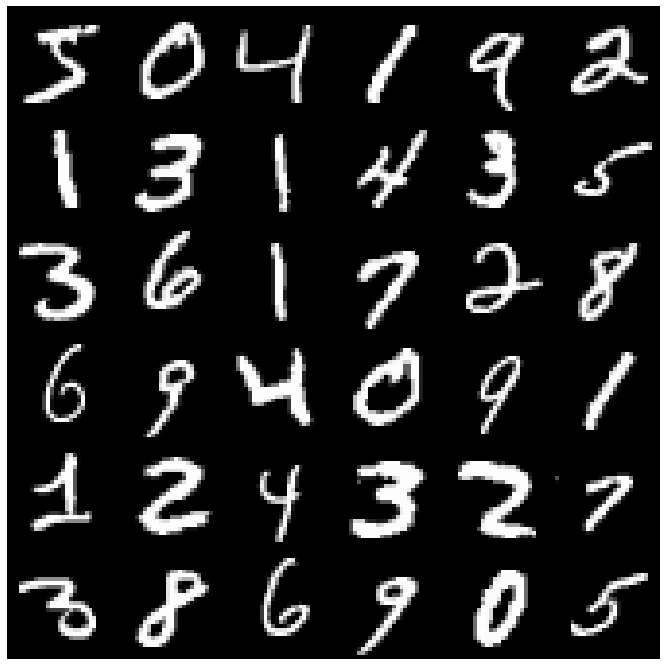

In [8]:
plot_montage(imgs)

In [9]:
class _NetTools:
    @staticmethod
    def _packed_views(shapes, dtype=np.float32):    
        sizes = [np.product(shape) for shape in shapes]
        total_size = np.sum(sizes)

        ends = np.cumsum(sizes)
        starts = np.roll(ends, 1)
        starts[0] = 0

        packed = np.zeros(total_size, dtype=dtype)
        views = tuple(packed[start:end].reshape(shape)
                      for start, end, shape in zip(starts, ends, shapes))

        return (packed,) + views

    @staticmethod
    def _init_weight(weight):
        fan_in, fan_out = weight.shape
        bound = np.sqrt(3. / fan_in)
        weight[...] = bound * (2. * np.random.random((fan_in, fan_out)) - 1.)
        return weight
    
    @staticmethod
    def _bias(x):
        return np.concatenate((x, np.ones(x.shape[0])[:, None]), axis=1)
    
    @staticmethod
    def softmax(x, eps=1e-8):
        mx = np.max((np.max(x), 0.0))
        terms = np.maximum(np.exp(x - mx), eps)
        denom = np.sum(terms, axis=1).reshape((-1, 1))
        return terms / denom


In [10]:
class Net(_NetTools):
    def __init__(self, in_chans, num_classes, num_hidden=128):
        self.parameters, self.hidden, self.visible = self._packed_views(
            ((in_chans + 1, num_hidden), (num_hidden + 1, num_classes)))
        self.reset_parameters()
        
    def reset_parameters(self):
        self._init_weight(self.hidden)
        self._init_weight(self.visible)

    def __call__(self, imgs):
        x = imgs.reshape((imgs.shape[0], -1))
        z = np.tanh(x @ self.hidden[:-1] + self.hidden[-1])
        v = z @ self.visible[:-1] + self.visible[-1]
        return self.softmax(v)
    
    def error(self, imgs, labels):
        likes = np.log(self(imgs))
        return -np.mean(likes[range(likes.shape[0]), labels])
    
    def predict(self, imgs):
        return np.argmax(self(imgs), axis=1)

In [11]:
net = Net(in_chans=28 * 28, num_classes=10, num_hidden=128)

In [12]:
net.parameters.size

101770

In [13]:
net.error(imgs, labels)

2.3120012

In [14]:
def alopex(net, *args, step_size=0.0025, forget_factor=0.1, max_iter=1_000, eps=1e-8):
    '''ALgorithm Of Pattern EXtraction (ALOPEX) 99/B version.
    '''
    # view into all of the network parameters
    params = net.parameters
    
    # initial error
    error = net.error(*args)
    error_prev = error
    error_hist = [error,]
    
    # exponentially weighted, running average of the
    # magnitude of the correlation
    corr_run = 0.
    corr_run_hist = [corr_run,]
    
    # probability of taking a negative step
    probs = np.ones_like(params) * 0.5
    
    momentum = np.ones_like(params)
    
    for i in (pbar := tqdm.trange(max_iter, desc='iteration')):
        # draw random steps based on probability of taking
        # a step in the negative direction
        draw = np.random.random(params.shape)
        dw = np.where(draw < probs, -step_size, step_size)
        params += dw

        # compute the error
        error_prev = error
        error = net.error(*args)
        error_hist.append(error)
        
        # current change in error
        de = error - error_prev

        # correlation metric
        corr = de * dw
        
        corr_mag = np.mean(np.abs(corr))
        corr_run = (((1. - forget_factor) * corr_run) + (forget_factor * corr_mag))
        corr_run = max(corr_run, eps)
        corr_run_hist.append(corr_run)
        
        # add error and running correlation to the progress bar
        pbar.set_postfix({'err': error, 'corr': corr_run})

        # probability of taking negative step
        # is drawn from the Boltzman Distribution
        probs[...] = 1. / (1. + np.exp(-corr / corr_run))

    return munch.Munch(
        error_hist=error_hist,
        corr_run_hist=corr_run_hist,
    )

In [15]:
def alopex2(net, *args, step_size=0.0025, forget_factor=0.1, alpha=0.001, max_iter=1_000, eps=1e-8):
    '''ALgorithm Of Pattern EXtraction (ALOPEX) 99/B version.
    '''
    # view into all of the network parameters
    params = net.parameters
    
    # initial error
    error = net.error(*args)
    error_prev = error
    error_hist = [error,]
    
    # exponentially weighted, running average of the
    # magnitude of the correlation
    corr_run = 0.
    corr_run_hist = [corr_run,]
    
    # probability of taking a negative step
    probs = np.ones_like(params) * 0.5
    
    momentum = np.ones_like(params)
    
    for i in (pbar := tqdm.trange(max_iter, desc='iteration')):
        # draw random steps based on probability of taking
        # a step in the negative direction
        draw = np.random.random(params.shape)
        dw = np.where(draw < probs, -step_size * momentum, step_size * momentum)
        params += dw

        # compute the error
        error_prev = error
        error = net.error(*args)
        error_hist.append(error)
        
        # current change in error
        de = error - error_prev
        
        # update the running average of the correlation
        #corr_mag = np.abs(de) * np.mean(np.abs(dw))
        #corr_run = (((1. - forget_factor) * corr_run) + (forget_factor * corr_mag))
        #corr_run = max(corr_run, eps)

        # correlation metric
        corr = de / dw
        #corr = de * dw
        
        #corr_mag = np.sqrt(np.mean(corr**2))
        corr_mag = np.mean(np.abs(corr))
        corr_run = (((1. - forget_factor) * corr_run) + (forget_factor * corr_mag))
        corr_run = max(corr_run, eps)
        corr_run_hist.append(corr_run)
        
        # add error and running correlation to the progress bar
        pbar.set_postfix({'err': error, 'corr': corr_run})

        # probability of taking negative step
        # is drawn from the Boltzman Distribution
        probs[...] = 1. / (1. + np.exp(-corr / corr_run))
        
        momentum = (1. - alpha) * momentum + alpha * corr_mag
        momentum = np.maximum(momentum, eps)

    return munch.Munch(
        error_hist=error_hist,
        corr_run_hist=corr_run_hist,
    )

In [52]:
net.reset_parameters()

result = alopex(net, imgs, labels, max_iter=2_000)

iteration:   0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(result.error_hist);
plt.grid();

In [ ]:
plt.plot(result.corr_run_hist);
plt.grid();

In [ ]:
l = net.predict(test_imgs[:36])
l.reshape((6, 6))

In [ ]:
plot_montage(test_imgs)

In [ ]:
def accuracy(y, g):
    return (y == g).mean()

In [ ]:
accuracy(net.predict(test_imgs), test_labels)

In [69]:
def alopex2(net, *args, step_size=0.0025, forget_factor=0.1, alpha=0.001, max_iter=1_000, eps=1e-8):
    '''ALgorithm Of Pattern EXtraction (ALOPEX) 99/B version.
    '''
    # view into all of the network parameters
    params = net.parameters
    
    # initial error
    error = net.error(*args)
    error_prev = error
    error_hist = [error,]
    
    # exponentially weighted, running average of the
    # magnitude of the correlation
    corr_run = 0.
    corr_run_hist = [corr_run,]
    
    # probability of taking a negative step
    probs = np.ones_like(params) * 0.5
    
    momentum = np.ones_like(params)
    
    for i in (pbar := tqdm.trange(max_iter, desc='iteration')):
        # draw random steps based on probability of taking
        # a step in the negative direction
        draw = np.random.random(params.shape)
        dw = np.where(draw < probs, -step_size / np.sqrt(momentum + eps), step_size / np.sqrt(momentum + eps))
        params += dw

        # compute the error
        error_prev = error
        error = net.error(*args)
        error_hist.append(error)
        
        # current change in error
        de = error - error_prev
        
        # update the running average of the correlation
        #corr_mag = np.abs(de) * np.mean(np.abs(dw))
        #corr_run = (((1. - forget_factor) * corr_run) + (forget_factor * corr_mag))
        #corr_run = max(corr_run, eps)

        # correlation metric
        corr = de / dw
        #corr = de * dw
        
        #corr_mag = np.sqrt(np.mean(corr**2))
        corr_mag = np.mean(np.abs(corr))
        corr_run = (((1. - forget_factor) * corr_run) + (forget_factor * corr_mag))
        corr_run = max(corr_run, eps)
        corr_run_hist.append(corr_run)
        
        # add error and running correlation to the progress bar
        pbar.set_postfix({'err': error, 'corr': corr_run})

        # probability of taking negative step
        # is drawn from the Boltzman Distribution
        probs[...] = 1. / (1. + np.exp(-corr / corr_run))
        
        momentum = (1. - alpha) * momentum + alpha * (corr**2)
        #momentum = np.maximum(momentum, eps)

    return munch.Munch(
        error_hist=error_hist,
        corr_run_hist=corr_run_hist,
    )

In [70]:
net.reset_parameters()

result2 = alopex2(net, imgs, labels, step_size=0.005, alpha=0.001, max_iter=2_000)

iteration:   0%|          | 0/2000 [00:00<?, ?it/s]

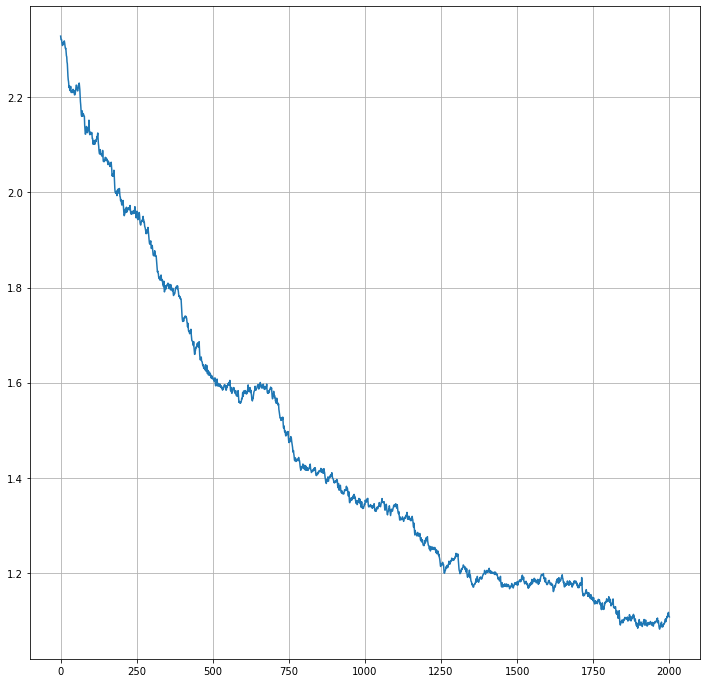

In [71]:
plt.plot(result2.error_hist);
plt.grid();

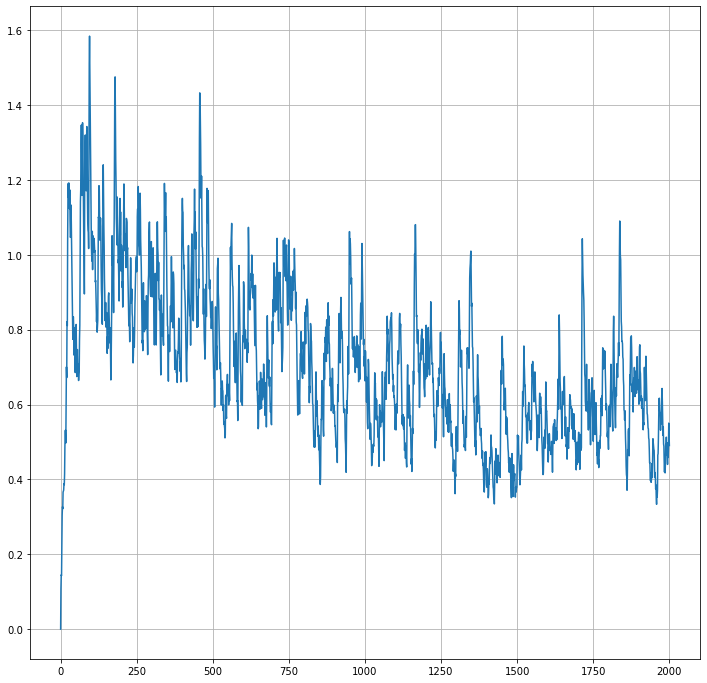

In [72]:
plt.plot(result2.corr_run_hist);
plt.grid();

In [73]:
l = net.predict(test_imgs[:36])
l.reshape((6, 6))

array([[7, 6, 1, 0, 9, 1],
       [8, 9, 2, 9, 0, 2],
       [4, 0, 1, 6, 7, 7],
       [6, 4, 9, 6, 1, 8],
       [4, 0, 4, 9, 0, 1],
       [7, 1, 8, 7, 7, 0]])

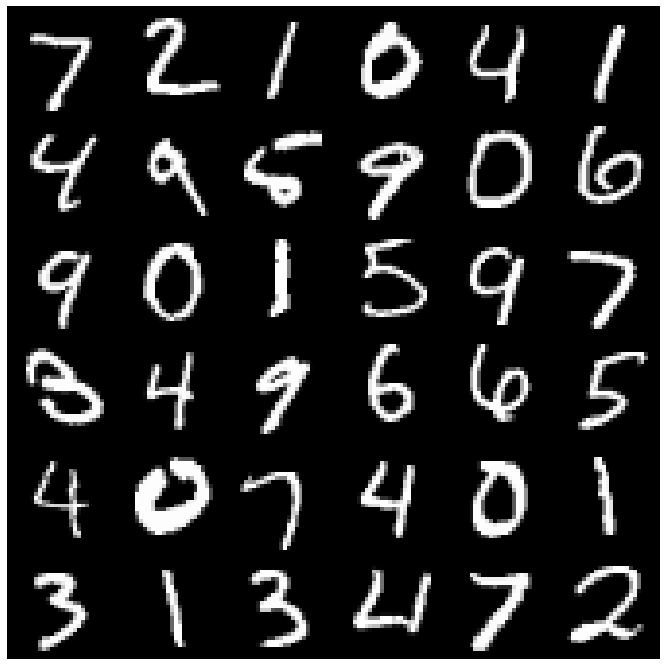

In [74]:
plot_montage(test_imgs)

In [75]:
def accuracy(y, g):
    return (y == g).mean()

In [76]:
accuracy(net.predict(test_imgs), test_labels)

0.6408